# Equilibrium Diagram of a Box Beam under Uniaxial Compression

***

In our [last notebook](10_On_the_Mechanical_Cause_of_the_Box_Beam_Bifurcation_Break.ipynb) we showed that the application of a bending load to a box beam results in an asymmetry of the internal loads about the midplane of the top skin. We consider this mechanism to be the cause of the broken supercritical pitchfork behavior observed for both the [unreinforced](06_Verification_of_SOL_106_Nonlinear_Buckling_Method.ipynb#tangent-stiffness-matrix) and the [reinforced box beam](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-buckling-method-verification). To prove that the bending load is indeed responsible for the observed response, in this notebook we are going to investigate the equilibrium diagram of a box beam under uniaxial compression, where we expect to find a supercritical pitchfork bifurcation. We are going carry out our investigation for both the unreinforced and the reinforced box beam configuration.

* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
* [Conclusion](#conclusion)

In [1]:
# Constants - Nastran card IDs
COMPRESSION_FORCE_SET_ID = 11
METHOD_SET_ID = 12

## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry and material properites as in our previous notebooks.

![Unreinforced box beam geometry.](resources/04_BoxBeamGeometry.svg "Unreinforced box beam geometry.")

In [2]:
AR = 9.0  # aspect ratio - 2*b/w (the length of the box beam corresponds to half the span of the CRM wing)
w = 1e3  # width [mm]
l = AR * w / 2  # length [mm]
non_dimensional_height = 0.2  # h/w
h = w * non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1 / 50  # t/h
t = h * non_dimensional_thickness  # shell thickness [mm]
print(
    f"""Box beam dimensions:
- width: {w/1e3:.2f} m
- length: {l/1e3:.2f} m
- height: {h/1e3:.2f} m
- wall thickness: {t:.2f} mm"""
)

Box beam dimensions:
- width: 1.00 m
- length: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


In [3]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_beam` from the `box_beam_utils` module. We prescribe an element length of 60 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Analysis_of_a_Box_Beam.ipynb#mesh-convergence).

In [4]:
from resources import box_beam_utils

element_length = 60  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_beam(
    width=w, length=l, height=h, element_length=element_length
)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object using the function `create_base_bdf_input`, where we define fixed boundary conditions at the root of the box beam.

In [5]:
unreinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E,
    poisson_ratio=nu,
    density=rho,
    shell_thickness=t,
    nodes_xyz_array=nodes_coordinates_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix,
)  # create BDF object
print(unreinforced_box_beam_bdf.get_bdf_stats())  # print cards of BDF object

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 3388

bdf.elements: 0
  CQUAD4   : 3344

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated load at the center of the tip section along the axial direction of the box beam, as shown below. We use a `RBE2` element to rigidly connect the nodes along the tip section to the node in the center.

![Unreinforced box beam under compression load.](resources/11_BoxBeamCompressionLoad.svg "Unreinforced box beam under compression load.")

In [6]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = element_length / 100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:, 1] - l) < tolerance]

# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam_bdf.add_grid(tip_section_master_node_id, [w / 2, l, 0.0])

# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam_bdf.elements) + 1
unreinforced_box_beam_bdf.add_rbe2(
    eid=rbe2_eid, gn=tip_section_master_node_id, cm="123456", Gmi=tip_nodes_ids
)

# Add concentrated force
compression_force_direction = [0.0, -1.0, 0.0]
pynastran_utils.add_uniform_force(
    bdf=unreinforced_box_beam_bdf,
    nodes_ids=[tip_section_master_node_id],
    set_id=COMPRESSION_FORCE_SET_ID,
    direction_vector=compression_force_direction,
)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling mode, in order to have a reference load for the nonlinear analysis.

Buckling load: 59061 N
Buckling mode:


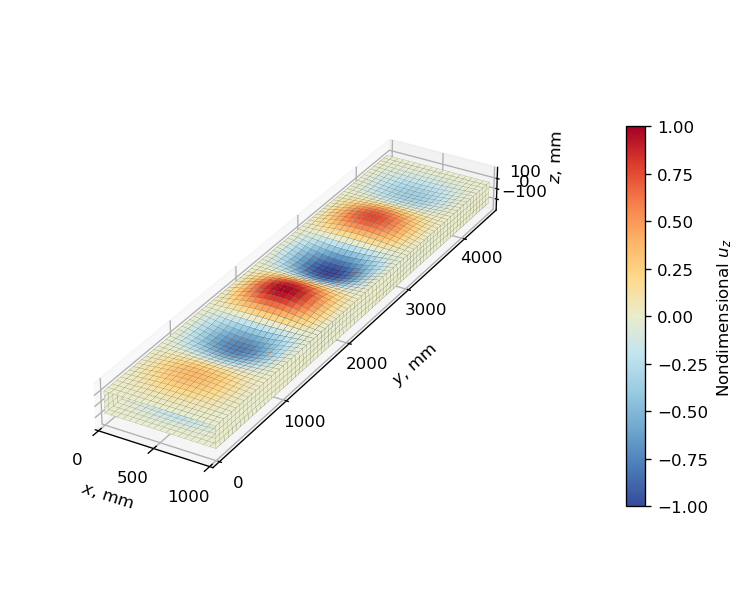

In [7]:
import os
from resources import pynastran_utils, plot_utils
import matplotlib.pyplot as plt

# Run SOL 105 and return OP2 object
analysis_directory_name = (
    "11_Equilibrium_Diagram_of_a_Box_Beam_Under_Uniaxial_Compression"
)
analysis_directory_path = os.path.join(os.getcwd(), "analyses", analysis_directory_name)
input_name = "unreinforced_box_beam_linear_buckling"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=unreinforced_box_beam_bdf.__deepcopy__(
        {}
    ),  # we pass a deep copy of the BDF object to be able to set up the nonlinear analysis later
    input_name=input_name,
    analysis_directory_path=analysis_directory_path,
    static_load_set_id=COMPRESSION_FORCE_SET_ID,
    method_set_id=METHOD_SET_ID,
    run_flag=False,
)


# Define function to adjust axes ticks and labels' position
def adjust_3d_plot(axes, colorbar=None):
    axes.locator_params(axis="x", nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of ticks of z-axis
    axes.tick_params(
        axis="y", which="major", pad=20
    )  # adjust position of ticks' label of y-axis
    axes.tick_params(
        axis="z", which="major", pad=6
    )  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label
    if colorbar is not None:
        colorbar.ax.set_position(
            colorbar.ax.get_position().shrunk(1.0, 0.66)
        )  # decrease colorbar size
        colorbar.ax.set_position(
            colorbar.ax.get_position().translated(0, 0.14)
        )  # move colorbar upwards


# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f"Buckling load: {sol_105_buckling_load:.0f} N")
plt.rcParams["figure.dpi"] = 120  # set default dpi of figures
print("Buckling mode:")
amplification_factor = 100
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2,
    subcase_id=2,
    displacement_component="tz",
    colormap="sunset",
    displacement_amplification_factor=amplification_factor,
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()

We observe that the shape of the first buckling mode predicted by SOL 105 is characterized by six alternating half-waves over each skin with a top-down symmetry.

### Nonlinear analysis <a name="unreinforced-nonlinear-analysis"></a>

Now we move on to the nonlinear analysis, that will allow us to prove the existence of a supercritical pitchfork bifurcation in the equilibrium diagram of the box beam.

To explore the bifurcation in the equilibrium diagram we need to add an imperfection to our structure. Similarly to the case of the [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and of the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we implement the imperfection adding a vertical force at the center of the top skin.

![Unreinforced box beam under transversal load.](resources/11_BoxBeamEccentricLoad.svg "Unreinforced box beam under transversal load.")

In [8]:
# Find id of node at the center of top skin
top_skin_central_node_id = (
    np.argmin(
        np.linalg.norm(
            nodes_coordinates_array - np.array([w / 2, l / 2, h / 2]), axis=1
        )
    )
    + 1
)  # calculate distance between nodes and center of the top skin and find index where distance is minimum

# Add FORCE card
vertical_force_set_id = (
    COMPRESSION_FORCE_SET_ID + 1
)  # define set idenfitification number of the FORCE card
vertical_force_direction = [0.0, 0.0, 1.0]  # define direction of the vertical force
pynastran_utils.add_uniform_force(
    bdf=unreinforced_box_beam_bdf,
    nodes_ids=[top_skin_central_node_id],
    set_id=vertical_force_set_id,
    direction_vector=vertical_force_direction,
)  # add FORCE card

Next we need to define our subcase sequence. We expect to find three branches departing from the bifurcation point, so our strategy will be to explore one branch at a time.

1. In the first subcase we explore branch corresponding to the zero-deflection branch of Euler's column. For this reason we apply only the compression load $P_y$ with a magnitude $P_y/P_{\text{SOL 105}}=1.5$, where $P_{\text{SOL 105}}$ is the buckling load predicted by SOL 105.
2. In subcase 2 we unload the structure.
3. Since we cannot directly explore the other branches, we use the third subcase as an intermediate step by applying a combined compression and vertical load, with $P_y/P_{\text{SOL 105}}=1.5$ and $P_z/P_{\text{SOL 105}}=1/100$.
4. In the fourth subcase we remove the vertical load and we leave only the compression load. In this way, the final load will be equal to the one of the first subcase, but we expect to find a different deformation state.
5. In subcase 5 we completely unload the structure, in order to walk the equilibrium path "backwards" to the bifurcation point and then to the ground state.
6. Similarly to subcase 3, the sixth subcase is an intermediate step to explore the other branch of the bifurcation. We apply the same load combination of subcase 3, but with the vertical load in the opposite direction.
7. In subcase 7 we remove the vertical load and we expect to find the monitored displacement equal in magnitude but opposite in sign with respect to the one found at the end of subcase 4.
8. In the eighth and last subcase we completely unload the structure to visualize the equilibrium path of the branch corresponding to the deformation state found in sucbase 7.


In [9]:
# Subcase 1
compression_load_set_id = 21  # define set identification number of LOAD card
compression_load_magnitude = sol_105_buckling_load * 1.5
unreinforced_box_beam_bdf.add_load(
    sid=compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID],
)
subcase_id = 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 2
zero_load_set_id = compression_load_set_id + 1
unreinforced_box_beam_bdf.add_load(
    sid=zero_load_set_id,
    scale=1.0,
    scale_factors=[0.0],
    load_ids=[COMPRESSION_FORCE_SET_ID],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

# Subcase 3
eccentric_compression_load_set_id = zero_load_set_id + 1
vertical_load_magnitude = sol_105_buckling_load / 100
unreinforced_box_beam_bdf.add_load(
    sid=eccentric_compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude, vertical_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID, vertical_force_set_id],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=eccentric_compression_load_set_id,
)

# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

# Subcase 6
opposite_eccentric_compression_load_set_id = eccentric_compression_load_set_id + 1
unreinforced_box_beam_bdf.add_load(
    sid=opposite_eccentric_compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude, -1 * vertical_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID, vertical_force_set_id],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=opposite_eccentric_compression_load_set_id,
)

# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=unreinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

Now it's time to set up the parameters of the nonlinear analysis. Preliminary tests showed the arc-length method had issues when trying to change the load application direction between successive subcases. For this reason, we only use the arc-length method for the first subcase, while we use the load control method for the remaining subcases. We set all nonlinear parameters to the values found in a [previous sensitivity study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#nonlinear-analysis-parameters), except for the value of the maximum allowable arc-length adjustment ratio, which we set to $1.1$. We use this value because in our preliminary tests we found that the arc-length method in the first subcase was not able to converge to the "zero-displacement" path of the supercritical pitchfork bifurcation with $MAXALR=1.01$, while it was able to do so with $MAXALR=1.1$.

We define the values of the nonlinear parameters and we use the functions `set_up_newton_method` and `set_up_arc_length_method` to set up the load control method and the arc-length method, respectively.

In [10]:
convergence_criteria = "PU"
load_tolerance = 1e-2
displacement_tolerance = 1e-2
initial_increment = 0.01
load_control_nlparm_id = 1
pynastran_utils.set_up_newton_method(
    bdf=unreinforced_box_beam_bdf,
    nlparm_id=load_control_nlparm_id,
    ninc=round(1 / initial_increment),
    conv=convergence_criteria,
    eps_u=displacement_tolerance,
    eps_p=load_tolerance,
)  # set up nonlinear analysis with load control method as default for all subcases
arc_length_nlparm_id = 2
pynastran_utils.set_up_arc_length_method(
    bdf=unreinforced_box_beam_bdf,
    nlparm_id=arc_length_nlparm_id,
    conv=convergence_criteria,
    eps_p=load_tolerance,
    eps_u=displacement_tolerance,
    ninc=round(1 / initial_increment),
    desiter=5,
    maxalr=1.1,
    maxinc=200,
    subcase_id=1,
)  # set up nonlinear analysis with arc-length method for subcase 1

Now we can run the analysis and plot the deformation of the box beam at the end of each subcase.

Nastran job unreinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 845.0 s
Subcase 1


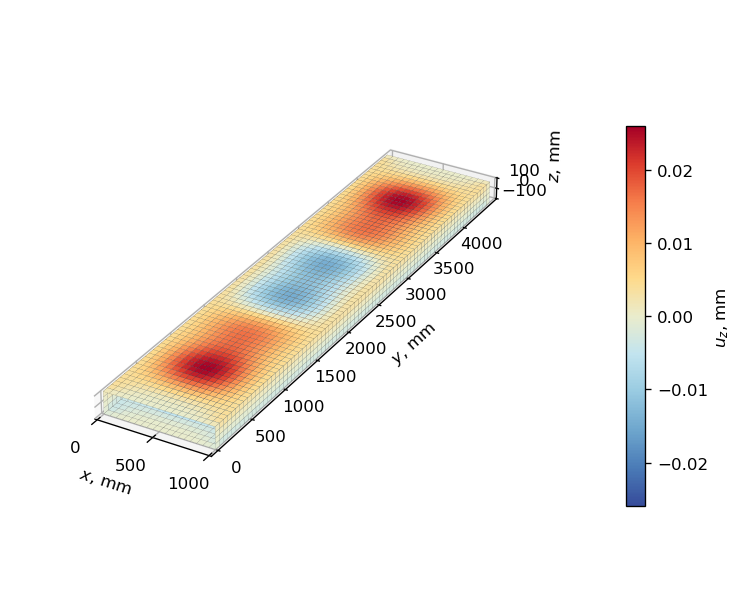

Subcase 2


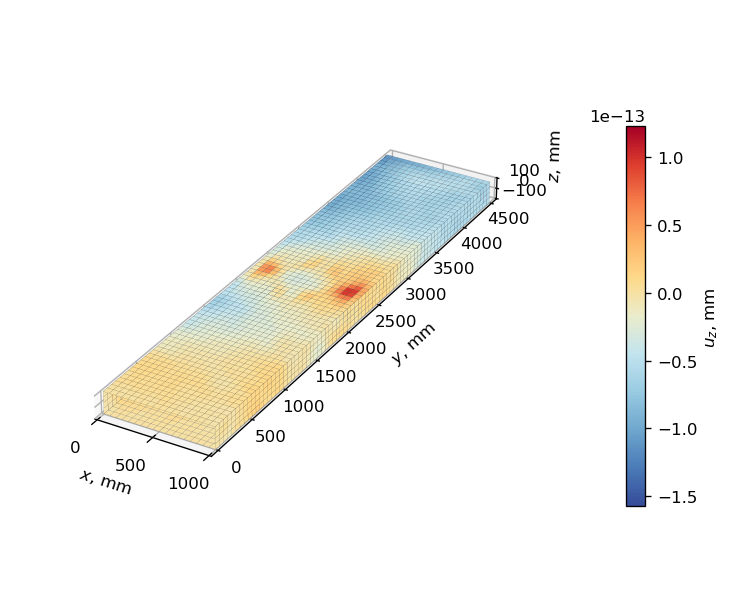

Subcase 3


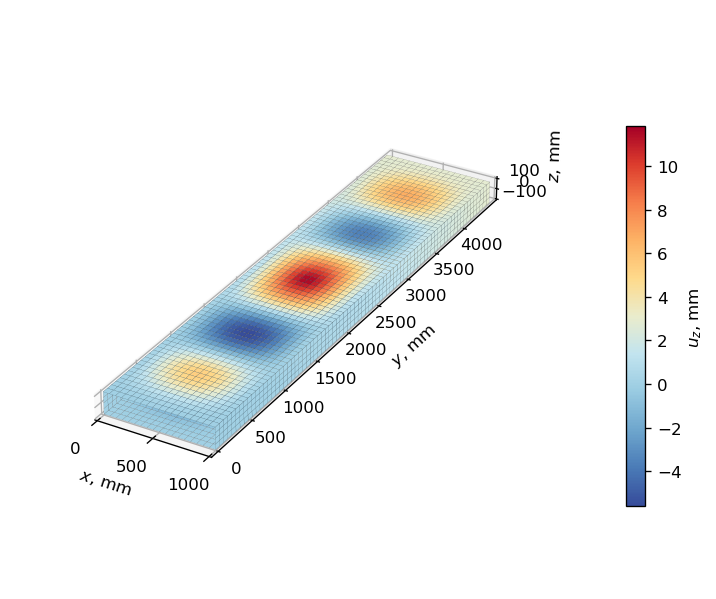

Subcase 4


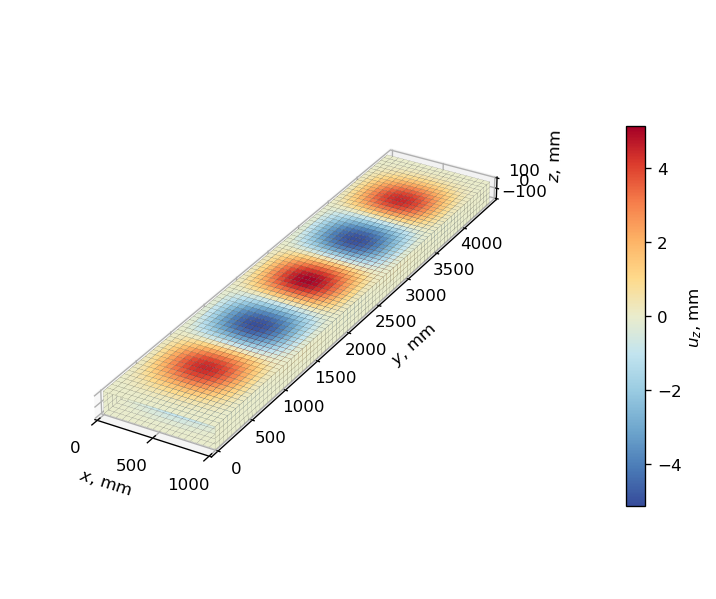

Subcase 5


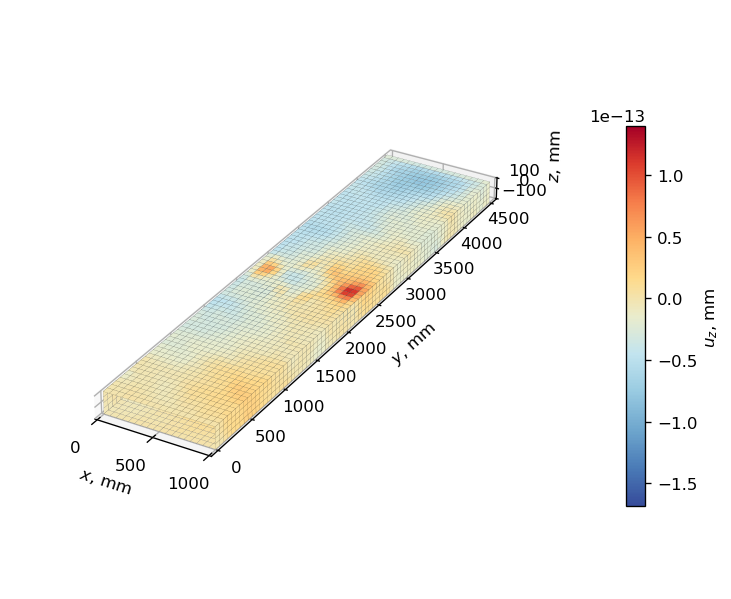

Subcase 6


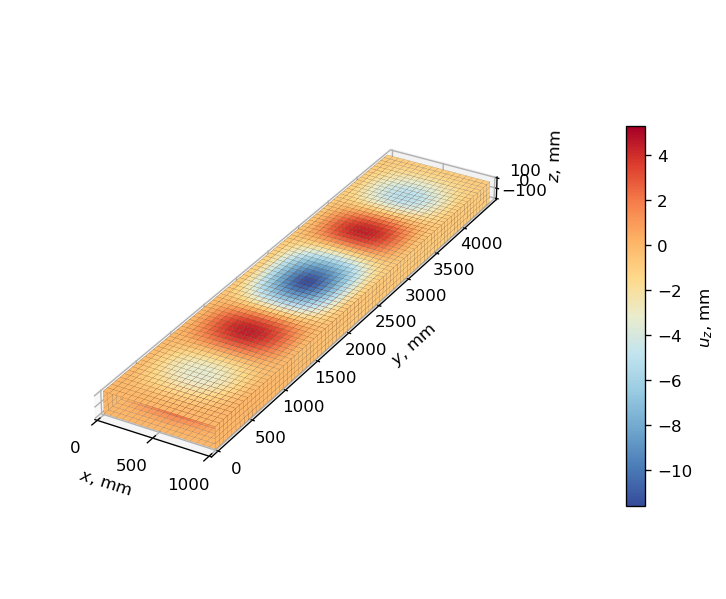

Subcase 7


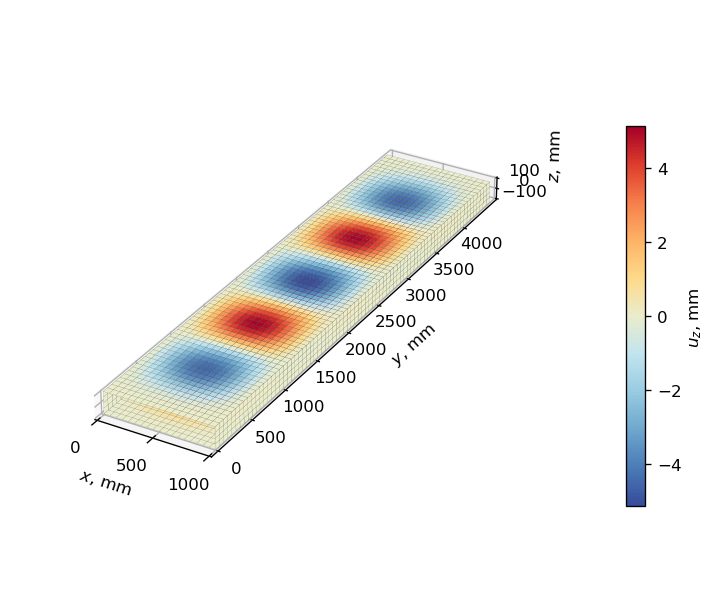

Subcase 8


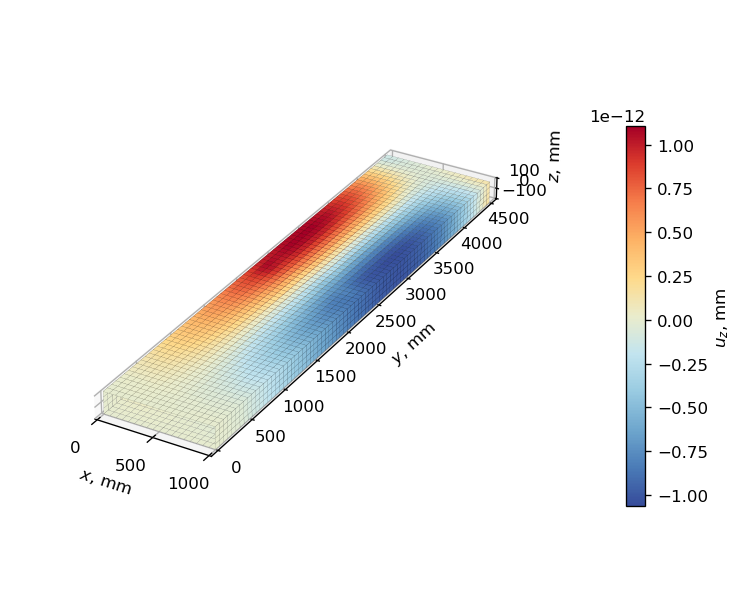

In [11]:
from pyNastran.op2.op2 import read_op2

# Run analysis
input_name = "unreinforced_box_beam_nonlinear_analysis"
pynastran_utils.run_analysis(
    bdf=unreinforced_box_beam_bdf,
    directory_path=analysis_directory_path,
    filename=input_name,
    run_flag=False,
)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + ".op2")
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Plot deformation
for i in range(1, subcase_id + 1):  # iterate through subcases
    print(f"\033[1mSubcase {i:d}")
    _, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2,
        subcase_id=i,
        displacement_component="tz",
        colormap="sunset",
        length_unit="mm",
    )  # plot final deformation
    adjust_3d_plot(ax, cbar)
    plt.show()

The displacement field obtained at the end of subcases 1, 4 and 7 is different, suggesting that there should be a bifurcation in the equilibrium diagram of our box beam. Furthermore, the displacement field at the end of subcases 4 and 7 appears to be equal and opposite, as expected.

Now we want to visualize the equilibrium diagram in terms of $P_y/P_{\text{SOL 105}}$, $P_z/P_{\text{SOL 105}}$ and the vertical displacement $u_z$ of a given node of the top skin. We choose to monitor the vertical displacement at a node that is approximately at the center of the first blob observed for subcases 4 and 7 looking from the root of the box beam ($x=w/2$, $y\approx670$ mm). We nondimensionalize the displacement with the width $w$ of the box beam.

Similarly to our investigation on [Euler's column](02_Supercritical_Pitchfork_Bifurcation_of_Euler_Column.ipynb) and on the [thin plate under uniaxial compression](03_Equilibrium_Diagram_of_a_Thin_Plate_under_Uniaxial_Compression.ipynb), we visualize the equilibrium diagram with both 2D and 3D plots.

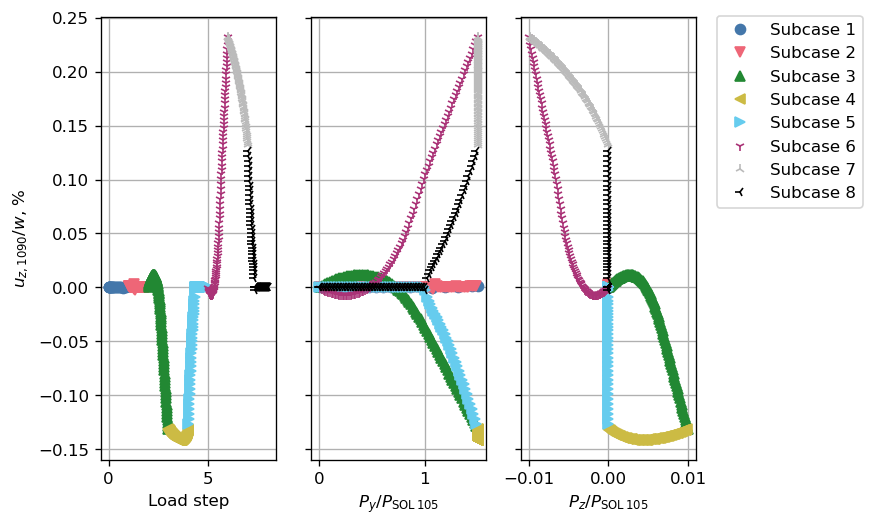

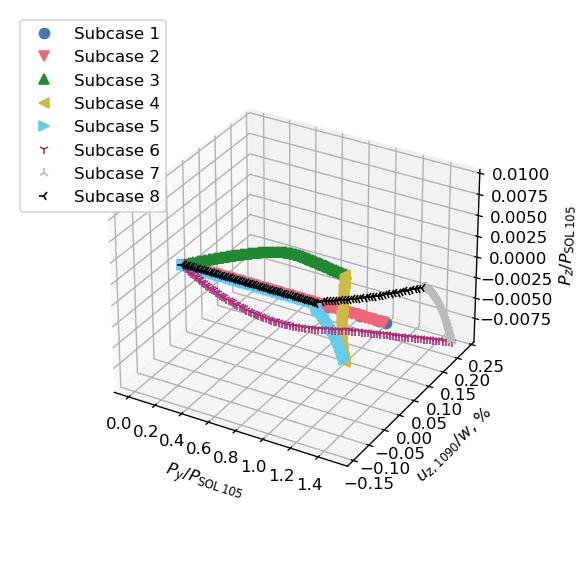

In [12]:
import tol_colors as tc  # package for colorblind-friendly colors
from matplotlib.lines import (
    Line2D,
)  # module including the list of all markers available in matplotlib

# # Set default color cycle to TOL bright for colorblind-friendly colors and store list of markers
plt.rc("axes", prop_cycle=plt.cycler("color", list(tc.tol_cset("bright"))))
markers = list(Line2D.markers.keys())[2:]


# Define function to plot 2D equilibrium diagram for each subcase
def plot_2d_equilibrium_diagram(disp, steps, loads, node_id):
    _, axs = plt.subplots(
        nrows=1, ncols=3, sharey="all"
    )  # create figure with 3 subplots
    for id in range(1, subcase_id + 1):  # iterate over subcases
        vertical_displacement = disp[id][:, 2]  # save displacement along z
        axs[0].plot(
            steps[id], vertical_displacement / w * 100, markers[id - 1]
        )  # plot load step vs displacement
        axs[1].plot(
            -loads[id][:, 1] / sol_105_buckling_load,
            vertical_displacement / w * 100,
            markers[id - 1],
        )  # plot applied load along y vs displacement, sign of load along y is inverted to show a positive load in the plot
        axs[2].plot(
            loads[id][:, 2] / sol_105_buckling_load,
            vertical_displacement / w * 100,
            markers[id - 1],
            label=f"Subcase {id:d}",
        )  # plot applied load along z vs displacement
    axs[0].set_xlabel("Load step")
    axs[0].set_ylabel(f"$u_{{z, {node_id:d}}}/w$, %")
    axs[0].grid(visible=True)
    axs[1].set_xlabel("$P_y/P_{\mathrm{SOL\,105}}$")
    axs[1].grid(visible=True)
    axs[2].set_xlabel("$P_z/P_{\mathrm{SOL\,105}}$")
    axs[2].grid(visible=True)
    axs[2].legend(loc="upper right", bbox_to_anchor=(2.0, 1.02))
    plt.show()


# Define function to plot 3D equilibrium diagram for each subcase
def plot_3d_equilibrium_diagram(disp, loads, node_id):
    plt.figure(figsize=(8, 6))  # create figure
    ax_3d = plt.axes(projection="3d")  # create three-dimensional axes
    # Plot applied load along y vs displacement vs applied load along z
    for id in disp:  # iterate over subcases
        ax_3d.plot3D(
            -loads[id][:, 1] / sol_105_buckling_load,
            disp[id][:, 2] / w * 100,
            loads[id][:, 2] / sol_105_buckling_load,
            markers[id - 1],
            label=f"Subcase {id:d}",
        )  # sign of load along y is inverted to show a positive load in the plot
    ax_3d.set_xlabel("$P_y/P_{\mathrm{SOL\,105}}$")
    ax_3d.xaxis.labelpad = 10
    ax_3d.set_ylabel(f"$u_{{z, {node_id:d}}}/w$, %")
    ax_3d.yaxis.labelpad = 10
    ax_3d.set_zlabel("$P_z/P_{\mathrm{SOL\,105}}$")
    ax_3d.tick_params(axis="z", which="major", pad=12)
    ax_3d.zaxis.labelpad = 24
    ax_3d.legend(loc="upper left")
    ax_3d.grid(visible=True)
    ax_3d.set_box_aspect(aspect=None, zoom=0.75)
    plt.show()


# Find id of monitor node
monitor_node_y = 670  # y-coordinate of monitor node [mm]
monitor_node_id = (
    np.argmin(
        np.linalg.norm(
            nodes_coordinates_array - np.array([w / 2, monitor_node_y, h / 2]), axis=1
        )
    )
    + 1
)  # find id of the closest node to the prescribed position

# Read load-displacement history from op2 file and plot equilibrium diagrams
load_steps, applied_loads, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[monitor_node_id]
    )
)
monitor_node_displacements = displacements[monitor_node_id]
plot_2d_equilibrium_diagram(
    monitor_node_displacements, load_steps, applied_loads, monitor_node_id
)
plot_3d_equilibrium_diagram(monitor_node_displacements, applied_loads, monitor_node_id)

These results demonstrate the presence of a supercritical pitchfork bifurcation.

## Reinforced box beam <a name="reinforced"></a>

***

### Setup of the numerical model <a name="reinforced-numerical-model"></a>

We consider the same geometry and material properties of the unreinforced box beam and reinforce the structure with a number of ribs based on a prescribed spacing of $w/2$.

In [13]:
ribs_spacing = w / 2  # half of box beam's width
no_ribs = int(np.ceil(l / ribs_spacing)) + 1  # calculate number of ribs
ribs_y_locations = np.linspace(0, l, no_ribs)  # calculate y-coordinates of the ribs

# Print information to screen
np.set_printoptions(precision=0)
print(f"Number of ribs: {no_ribs:.0f}")
print(f"Ribs' y-coordinate [mm]:")
print(ribs_y_locations)

Number of ribs: 10
Ribs' y-coordinate [mm]:
[   0.  500. 1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500.]


We create a mesh of quadrilateral elements using the function `mesh_box_beam_with_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 60 mm based on the results of a previous [mesh convergence study](08_Nonlinear_Buckling_Analysis_of_a_Box_Beam_Reinforced_with_Ribs.ipynb#mesh-convergence).

In [14]:
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_reinforced_with_ribs(
    ribs_y_coordinates=ribs_y_locations,
    width=w,
    height=h,
    element_length=element_length,
)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Successively we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [15]:
reinforced_box_beam_bdf = box_beam_utils.create_base_bdf_input(
    young_modulus=E,
    poisson_ratio=nu,
    density=rho,
    shell_thickness=t,
    nodes_xyz_array=nodes_coordinates_array,
    nodes_connectivity_matrix=nodes_connectivity_matrix,
)
print(reinforced_box_beam_bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 4514

bdf.elements: 0
  CQUAD4   : 4680

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Let's apply the same compression force used for the unreinforced box beam. This time we use a `RBE3` element to connect the nodes along the outer edges of the tip section to the node in the center as the rigidity of the tip is already enforced by the presence of a physical rib.

In [16]:
# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
outer_tip_nodes_ids = nodes_ids[
    (np.abs(nodes_coordinates_array[:, 1] - l) < tolerance)
    & (
        (nodes_coordinates_array[:, 0] < tolerance)
        | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance)
        | (np.abs(nodes_coordinates_array[:, 2] - h / 2) < tolerance)
        | (np.abs(nodes_coordinates_array[:, 2] + h / 2) < tolerance)
    )
]  # nodes along the edges of the tip section

# Add master node at the center of the tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam_bdf.add_grid(tip_section_master_node_id, [w / 2, l, 0.0])

# Add RBE3 card to connect master node with outer nodes of the tip section
rbe3_eid = len(reinforced_box_beam_bdf.elements) + 1
reinforced_box_beam_bdf.add_rbe3(
    eid=rbe3_eid,
    refgrid=tip_section_master_node_id,
    refc="123456",
    weights=[1.0] * len(outer_tip_nodes_ids),
    comps=["123456"] * len(outer_tip_nodes_ids),
    Gijs=outer_tip_nodes_ids,
)

# Add FORCE card
pynastran_utils.add_uniform_force(
    bdf=reinforced_box_beam_bdf,
    nodes_ids=[tip_section_master_node_id],
    set_id=COMPRESSION_FORCE_SET_ID,
    direction_vector=compression_force_direction,
)

### Linear buckling analysis <a name="reinforced-linear-buckling"></a>

We use SOL 105 to calculate the linear buckling load and the corresponding buckling mode, so that we have a reference for the nonlinear analysis.

Nastran job reinforced_box_beam_linear_buckling.bdf completed
Wall time: 2.0 s
Buckling load: 104881 N
Buckling mode:


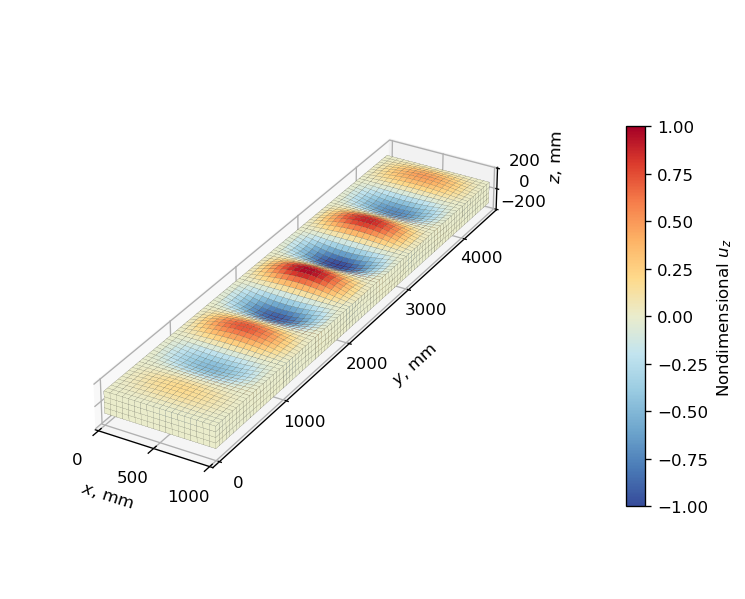

In [17]:
# Run SOL 105 and return OP2 object
input_name = "reinforced_box_beam_linear_buckling"
sol_105_op2 = pynastran_utils.run_sol_105(
    bdf=reinforced_box_beam_bdf.__deepcopy__(
        {}
    ),  # we pass a deep copy of the BDF object to be able to set up the nonlinear analysis later
    input_name=input_name,
    analysis_directory_path=analysis_directory_path,
    static_load_set_id=COMPRESSION_FORCE_SET_ID,
    method_set_id=METHOD_SET_ID,
    run_flag=False,
)

# Print critical buckling load and plot mode
sol_105_buckling_load = sol_105_op2.eigenvectors[2].eigr
print(f"Buckling load: {sol_105_buckling_load:.0f} N")
print("Buckling mode:")
_, ax, cbar = plot_utils.plot_eigenvector(
    op2=sol_105_op2,
    subcase_id=2,
    displacement_component="tz",
    colormap="sunset",
    displacement_amplification_factor=amplification_factor,
    length_unit="mm",
)
adjust_3d_plot(ax, cbar)
plt.show()

As expected, the buckling load of the reinforced configuration is larger than the one of the unreinforced configuration. The critical buckling mode consists of nine alternating half waves over each skin, corresponding to one for each rib bay, with a top-down symmetry.

### Nonlinear analysis <a name="reinforced-nonlinear-analysis"></a>

Also for the reinforced configuration we want to show the existence of a supercritical pitchfork bifurcation in the equilibrium diagram. As a consequence, we add the vertical force, create the subcase sequence, and define the load control and arc-length methods in the same way as done for the unreinforced configuration.

In [18]:
# Find id of node at the center of top skin
top_skin_central_node_id = (
    np.argmin(
        np.linalg.norm(
            nodes_coordinates_array - np.array([w / 2, l / 2, h / 2]), axis=1
        )
    )
    + 1
)  # calculate distance between nodes and center of the top skin and find index where distance is minimum

# Add FORCE card to apply vertical load
pynastran_utils.add_uniform_force(
    bdf=reinforced_box_beam_bdf,
    nodes_ids=[top_skin_central_node_id],
    set_id=vertical_force_set_id,
    direction_vector=vertical_force_direction,
)

# Subcase 1
compression_load_magnitude = sol_105_buckling_load * 1.5
reinforced_box_beam_bdf.add_load(
    sid=compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID],
)
subcase_id = 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 2
reinforced_box_beam_bdf.add_load(
    sid=zero_load_set_id,
    scale=1.0,
    scale_factors=[0.0],
    load_ids=[COMPRESSION_FORCE_SET_ID],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

# Subcase 3
vertical_load_magnitude = sol_105_buckling_load / 100
reinforced_box_beam_bdf.add_load(
    sid=eccentric_compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude, vertical_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID, vertical_force_set_id],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=eccentric_compression_load_set_id,
)

# Subcase 4
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 5
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

# Subcase 6
reinforced_box_beam_bdf.add_load(
    sid=opposite_eccentric_compression_load_set_id,
    scale=1.0,
    scale_factors=[compression_load_magnitude, -1 * vertical_load_magnitude],
    load_ids=[COMPRESSION_FORCE_SET_ID, vertical_force_set_id],
)
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=opposite_eccentric_compression_load_set_id,
)

# Subcase 7
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf,
    subcase_id=subcase_id,
    load_set_id=compression_load_set_id,
)

# Subcase 8
subcase_id = subcase_id + 1
pynastran_utils.create_static_load_subcase(
    bdf=reinforced_box_beam_bdf, subcase_id=subcase_id, load_set_id=zero_load_set_id
)

# Set up nonlinear analysis methods
pynastran_utils.set_up_newton_method(
    bdf=reinforced_box_beam_bdf,
    nlparm_id=load_control_nlparm_id,
    ninc=round(1 / initial_increment),
    conv=convergence_criteria,
    eps_u=displacement_tolerance,
    eps_p=load_tolerance,
)  # set up nonlinear analysis with load control method as default for all subcases
pynastran_utils.set_up_arc_length_method(
    bdf=reinforced_box_beam_bdf,
    nlparm_id=arc_length_nlparm_id,
    conv=convergence_criteria,
    eps_p=load_tolerance,
    eps_u=displacement_tolerance,
    ninc=round(1 / initial_increment),
    desiter=5,
    maxalr=1.1,
    maxinc=200,
    subcase_id=1,
)  # set up nonlinear analysis with arc-length method for subcase 1

We run the analysis and plot the deformation at the end of each subcase.

Nastran job reinforced_box_beam_nonlinear_analysis.bdf completed
Wall time: 1213.0 s
Subcase 1


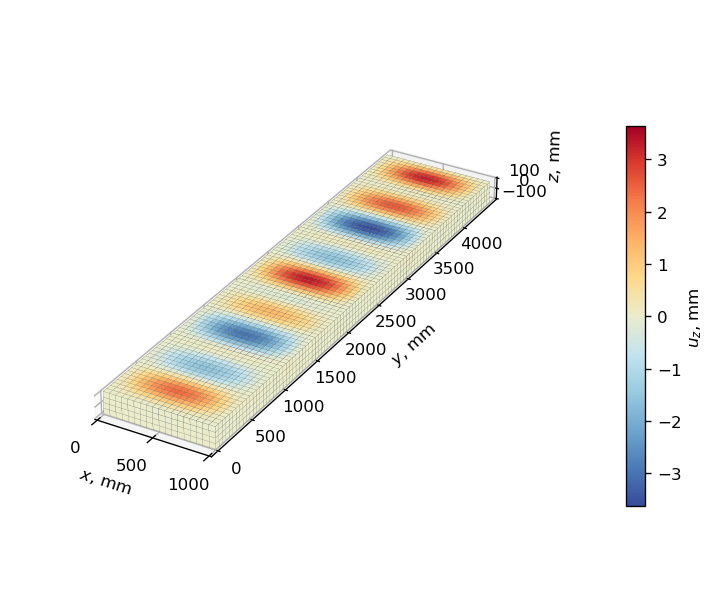

Subcase 2


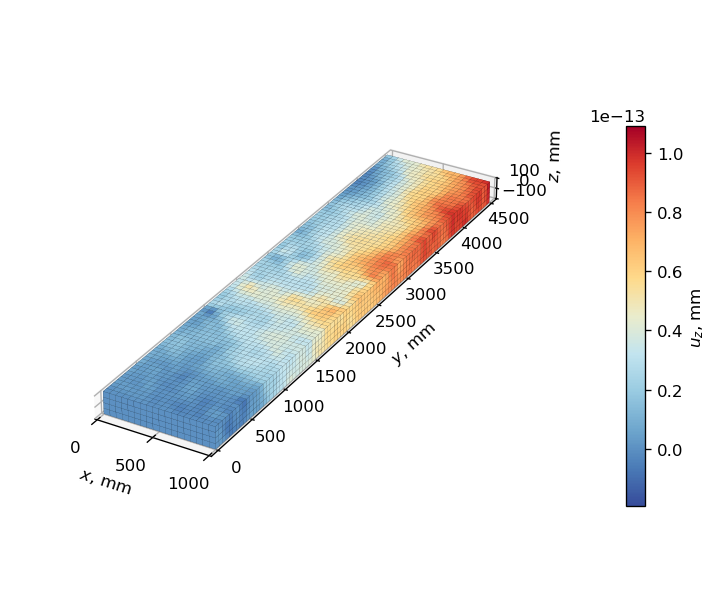

Subcase 3


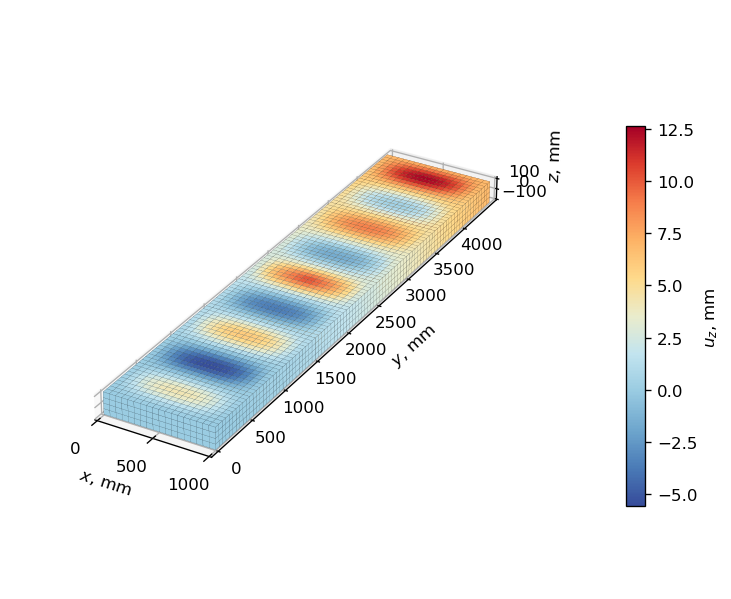

Subcase 4


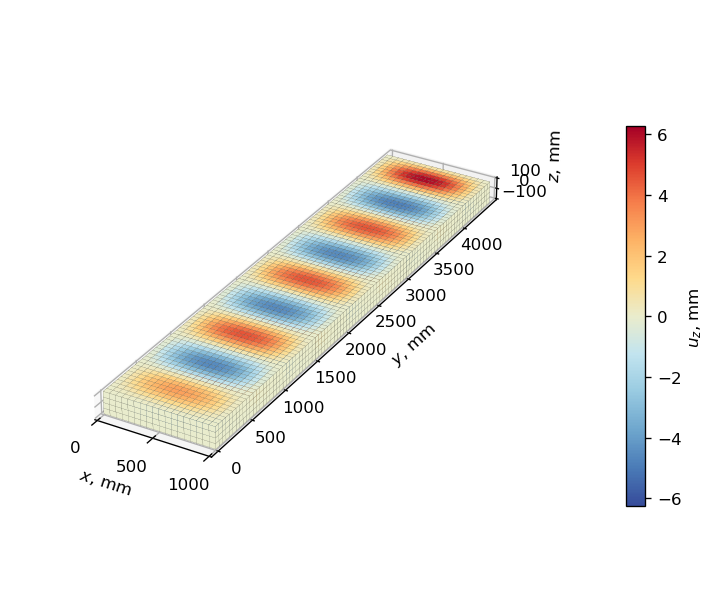

Subcase 5


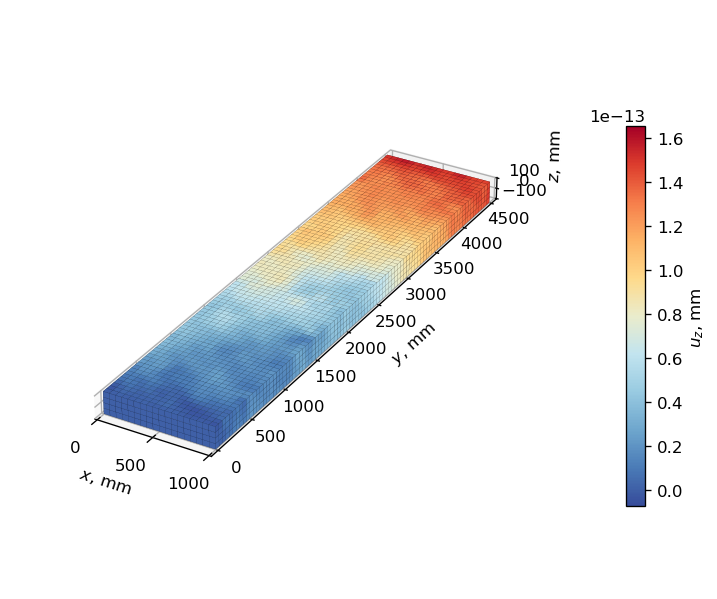

Subcase 6


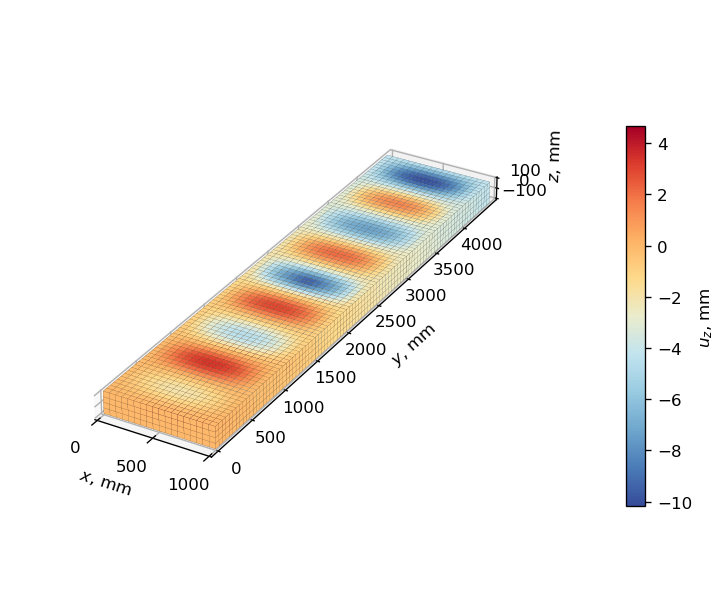

Subcase 7


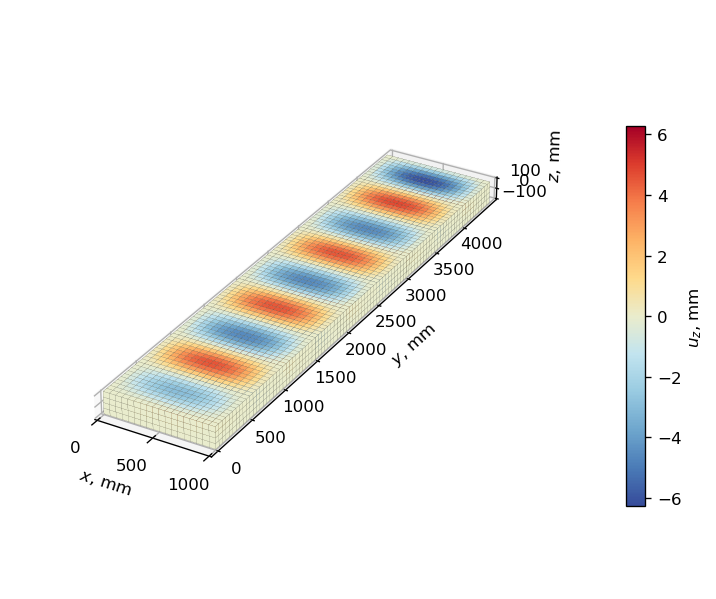

Subcase 8


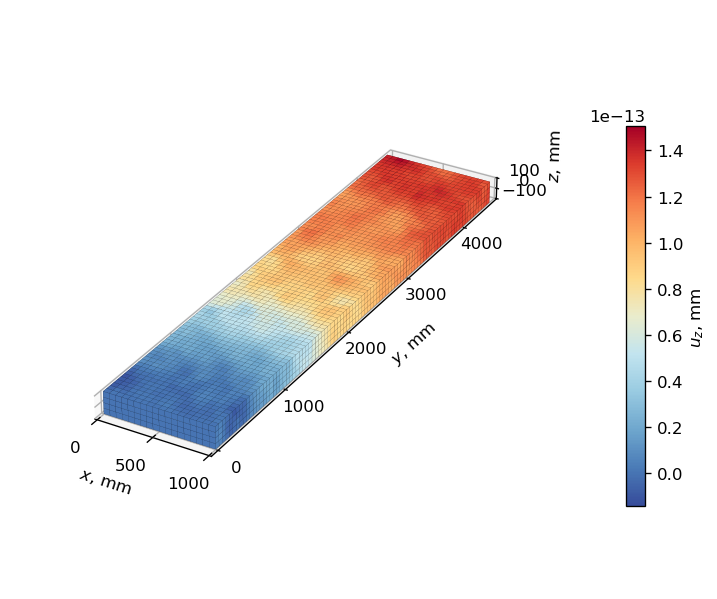

In [19]:
# Run analysis
input_name = "reinforced_box_beam_nonlinear_analysis"
pynastran_utils.run_analysis(
    bdf=reinforced_box_beam_bdf,
    directory_path=analysis_directory_path,
    filename=input_name,
    run_flag=False,
)

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + ".op2")
sol_106_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Plot deformation
for i in range(1, subcase_id + 1):  # iterate through subcases
    print(f"\033[1mSubcase {i:d}")
    _, ax, cbar = plot_utils.plot_deformation(
        op2=sol_106_op2,
        subcase_id=i,
        displacement_component="tz",
        colormap="sunset",
        length_unit="mm",
    )  # plot final deformation
    adjust_3d_plot(ax, cbar)
    plt.show()

Once again, we can observe a different displacement field at the end of subcases 1, 4 and 7. This result suggests the presence of a supercritical pitchfork bifurcation also in the equilibrium diagram of the reinforced box beam. Furthermore, the displacement field at the end of subcases 4 and 7 appears to be equal and opposite, similarly to what we observed for the unreinforced box beam.

Let's plot the 2D and 3D equilibrium diagram now. Also in this case we want to monitor the vertical displacement $u_z$ at the node that is approximately at the center of the first blob observed in subcases 4 and 7, so we change the queried $y$ coordinate accordingly ($y\approx320$ mm).

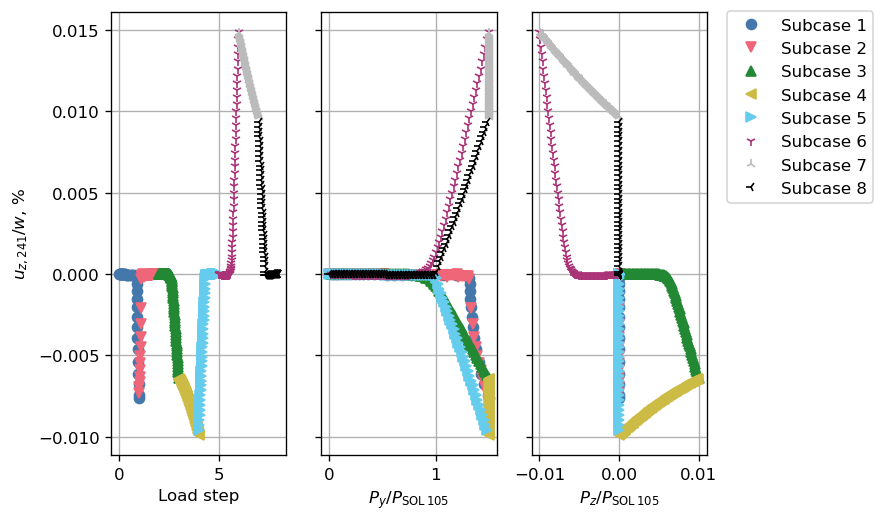

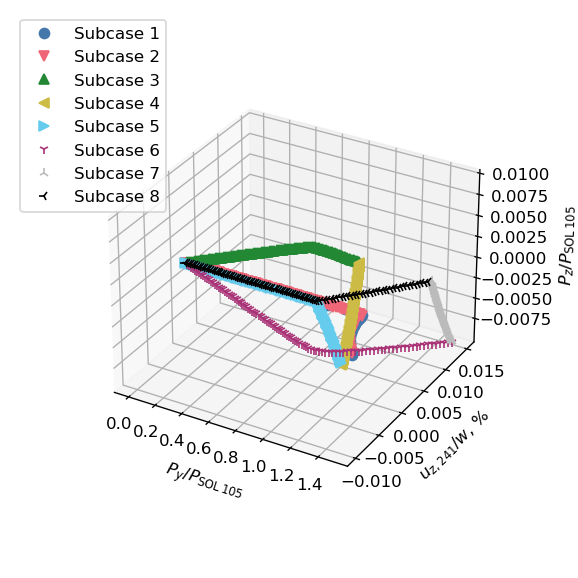

In [20]:
# Read load and displacement history of all subcases
monitor_node_y = 320  # y-coordinate of monitor node [mm]
monitor_node_id = (
    np.argmin(
        np.linalg.norm(
            nodes_coordinates_array - np.array([w / 2, monitor_node_y, h / 2]), axis=1
        )
    )
    + 1
)  # find the closest node to the prescribed position
load_steps, applied_loads, displacements = (
    pynastran_utils.read_load_displacement_history_from_op2(
        op2=sol_106_op2, node_ids=[monitor_node_id]
    )
)  # read load displacement history

# Plot 2D and 3D equilibrium diagrams
monitor_node_displacements = displacements[monitor_node_id]
plot_2d_equilibrium_diagram(
    monitor_node_displacements, load_steps, applied_loads, monitor_node_id
)
plot_3d_equilibrium_diagram(monitor_node_displacements, applied_loads, monitor_node_id)

The plot above depicts the presence of a supercritical pitchfork bifurcation, with the bifurcation point located at $P_y/P_{\text{SOL 105}}=1$. We can also observe what looks like another bifurcation point at approximately $P_y/P_{\text{SOL 105}}=1.2$, as the branch represented by the first subcase deviates from the zero-displacement line. The reason why this happens might be related to a number of factors, including the parameters of the arc-length method or its implementation in Nastran, and is difficult to ascertain without further investigation. However, since we were mainly interested in demonstrating the presence of a bifurcation at $P_y/P_{\text{SOL 105}}=1$, that is out of the scope of this notebook.


## Conclusion <a name="conclusion"></a>

***

In this notebook we have demonstrated the presence of a supercritical pitchfork bifurcation in the equilibrium diagram of a box beam when we apply a uniaxial compression load rather than a bending load. As a consequence, we can conclude that the asymmetry introduced by the bending load is responsible for the broken supercritical pitchfork response observed in our previous notebooks.